In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
from sklearn import metrics
import lightgbm as lgb

sys.path.append('../')
from pipelines import solution_1
import pipeline_config as cfg

EXPERIMENT_DIR = 'YOUR/PATH/TO/EXPERIMETS'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Solution 1

Local CV: **0.2278**
Public LB: **0.2351**

In [3]:
solution_1(cfg.SOLUTION_CONFIG, train_mode=True)

## Feature Extraction
* price features - for now just the price value
* target encoded features - likelihood encoding for categorical features
* groupby aggregations - features calculated based on aggregated categories

```python
    'groupby_aggregation': {'groupby_aggregations': [
        {'groupby': ['user_id'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['user_id'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['user_id'], 'select': 'parent_category_name', 'agg': 'nunique'},
        {'groupby': ['parent_category_name'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['parent_category_name'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['parent_category_name', 'category_name'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['parent_category_name', 'category_name'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['region'], 'select': 'parent_category_name', 'agg': 'count'},
        {'groupby': ['city'], 'select': 'parent_category_name', 'agg': 'count'},
    ]},
```

## Models
* lightgbm with the following parameters

```yaml
  lgbm_random_search_runs: 0
  lgbm__boosting_type: 'gbdt'
  lgbm__objective: regression
  lgbm__metric: RMSE
  lgbm__number_boosting_rounds: 300
  lgbm__early_stopping_rounds: 30
  lgbm__learning_rate: 0.05
  lgbm__num_leaves: 77
  lgbm__max_depth: 11
  lgbm__min_child_samples: 44
  lgbm__max_bin: 379
  lgbm__subsample: 0.82
  lgbm__subsample_freq: 2
  lgbm__colsample_bytree: 0.27
  lgbm__min_child_weight: 4
  lgbm__reg_lambda: 0.0
  lgbm__reg_alpha: 0.1
```

## Result Exploration

In [30]:
prediction_filepath = os.path.join(EXPERIMENT_DIR, 'solution_1', 'evaluation_predictions.csv')
evaluation_predictions =  pd.read_csv(prediction_filepath)

In [31]:
top_n = 100
best_predictions = evaluation_predictions.sort_values('score', ascending=True)[:top_n]
worst_predictions = evaluation_predictions.sort_values('score', ascending=False)[:top_n]

In [41]:
worst_predictions.head(3)

item_id       user_id                region          city  \
300684  6f9064244726  cb6537262a06  Свердловская область  Екатеринбург   
300683  b0b51242ab46  4fad0ffde337   Челябинская область     Челябинск   
300682  9ef9b4a32761  89bb5197f4d9    Краснодарский край          Сочи   

       parent_category_name              category_name            param_1  \
300684               Услуги          Предложение услуг  Красота, здоровье   
300683      Для дома и дачи            Бытовая техника          Для кухни   
300682      Для дома и дачи  Посуда и товары для кухни             Посуда   

                                  param_2 param_3  \
300684                                NaN     NaN   
300683  Холодильники и морозильные камеры     NaN   
300682                                NaN     NaN   

                                        title  \
300684  Парикмахер на дому и с выездом на дом   
300683                 Холодильник stinol-123   
300682                                 Кувшин   

                                              description   price  \
300684  Дорогие девушки и женщины! Стилист, с опытом р...     NaN   
300683  включается, работает, но не морозит. требуется...  1500.0   
300682                                  стеклянный кувшин   800.0   

        item_seq_number activation_date user_type  \
300684              763      2017-03-15   Company   
300683               42      2017-03-18   Private   
300682                9      2017-03-25   Company   

                                                    image  image_top_1  \
300684  d4953d3d17cf4d2437d748d0cda5c70d3a4c3053ca4e9d...        248.0   
300683  c323d4d569abf5884d5e77b577f872f0fcd9b58763c8e5...       1787.0   
300682  a1d66a59bd2b3139af6ee4c708bb9d0e04375b296a6725...       1635.0   

        deal_probability    y_pred     score  
300684           1.00000  0.111450  0.888550  
300683           0.00000  0.878592  0.878592  
300682           0.86521  0.000000  0.865210

## Model exploration

In [33]:
model_filepath = os.path.join(EXPERIMENT_DIR, 'solution_1', 'transformers','light_gbm')
light_gbm_model = joblib.load(model_filepath)

### Learning Curve

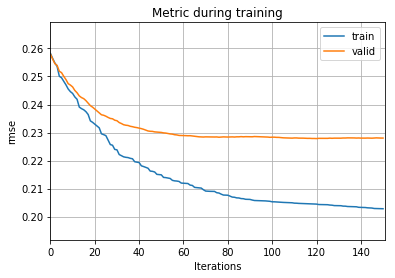

In [37]:
ax = lgb.plot_metric(light_gbm_model['evals_result'], metric='rmse')
plt.show()

### Feature Importance

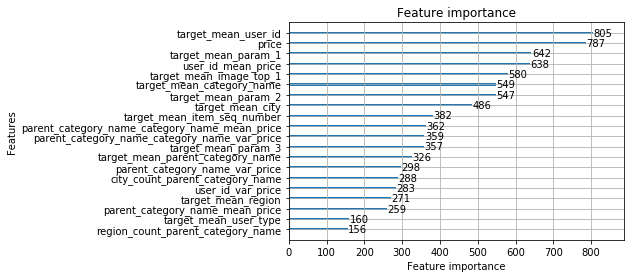

In [40]:
ax = lgb.plot_importance(light_gbm_model['estimator'], max_num_features=20)
plt.show()